# Using a string kernel on the Photoswitch dataset using the SMILES representation

<a target="_blank" href="https://colab.research.google.com/github/leojklarner/gauche/blob/main/notebooks/string_kernel_example.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

In [9]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
!pip install gauche --quiet

### Import and Utils


In [10]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error

In [11]:
from botorch import fit_gpytorch_model
from botorch.models import SingleTaskGP
from botorch.models.fully_bayesian import MIN_INFERRED_NOISE_LEVEL
from botorch.models.transforms import Normalize, Standardize
from gpytorch.constraints import GreaterThan
from gpytorch.kernels import ScaleKernel
from gpytorch.likelihoods import GaussianLikelihood
from gpytorch.mlls import ExactMarginalLogLikelihood
from gpytorch.priors import GammaPrior

In [12]:
from gauche.dataloader import MolPropLoader
from gauche.dataloader.data_utils import transform_data
from gauche.kernels.string_kernels.sskkernel import pad, encode_string, build_one_hot, SubsequenceStringKernel

In [13]:
# plotting util
def cv_plot(median, q1, q2, y_test):
    fig, ax = plt.subplots(1, 1, figsize=(8, 6))
    ax.plot([torch.min(median), torch.max(median)], [torch.min(median), torch.max(median)], "b--", lw=2)
    yerr1, yerr2 = median - q1, q2 - median
    yerr = torch.cat((yerr1.unsqueeze(0), yerr2.unsqueeze(0)), dim=0).squeeze(-1)
    markers, caps, bars = ax.errorbar(
        y_test.squeeze(-1).cpu(),
        median.squeeze(-1).cpu(),
        yerr=yerr.cpu(),
        fmt=".",
        capsize=4,
        elinewidth=2.0,
        ms=14,
        c="k",
        ecolor="gray",
    )
    [bar.set_alpha(0.8) for bar in bars]
    [cap.set_alpha(0.8) for cap in caps]
    ax.set_xlabel("True value", fontsize=20)
    ax.set_ylabel("Predicted value", fontsize=20)
    ax.set_aspect("equal")
    ax.grid(True)


In [14]:
# Use GPU if available or default to CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
tkwargs = {"dtype": torch.float, "device": device}
print(tkwargs)

{'dtype': torch.float32, 'device': device(type='cuda')}


### Data setup

In [15]:
# Regression experiments parameters, number of random splits and split size
n_trials = 20
test_set_size = 0.2

In [16]:
dataset = 'Photoswitch'
loader = MolPropLoader()
loader.load_benchmark("Photoswitch")
smiles = loader.features
targets = loader.labels
print(f'len(smiles) {len(smiles)} | len(targets) {len(targets)}')

Found 13 invalid labels [nan nan nan nan nan nan nan nan nan nan nan nan nan] at indices [41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 158]
To turn validation off, use dataloader.read_csv(..., validate=False).
len(smiles) 392 | len(targets) 392


In [17]:
maxlen = np.max([len(x) for x in smiles])
# get alphabet of characters used in candidate set (to init SSK)
alphabet = list({l for word in smiles for l in word})
print(f'alphabet \n {alphabet} \n length of alphabet {len(alphabet)}')
print(f'maxlen {maxlen}')

alphabet 
 ['n', 'O', 'o', 'B', '[', 'C', '#', '(', ']', '-', 'N', 'H', 'I', 'S', '3', 'F', 's', '+', '2', '1', '4', 'r', '=', 'l', ')', 'c'] 
 length of alphabet 26
maxlen 79


### Model Fits and Prediction

In [18]:
def get_gp_model(X, Y):
    likelihood = GaussianLikelihood(
        noise_prior=GammaPrior(torch.tensor(0.9, **tkwargs), torch.tensor(10.0, **tkwargs)),
        noise_constraint=GreaterThan(MIN_INFERRED_NOISE_LEVEL),
    )
    covar_module = ScaleKernel(  # Use the same lengthscale prior as in the TuRBO paper
        SubsequenceStringKernel(embds, index, alphabet, maxlen, **tkwargs),
    )
    gp_model = SingleTaskGP(
        train_X=X,
        train_Y=Y,
        outcome_transform=Standardize(1),
        likelihood=likelihood,
        covar_module=covar_module,
    )
    mll = ExactMarginalLogLikelihood(model=gp_model, likelihood=gp_model.likelihood)
    # ideally we can optimize over the kernel hyper-parameters of the string kernel
    # however, the gpu memory usage in batch (GPU) version of the kernel is quite high
    # while the standard non-batch version is relatively slow for kernel evaluation.
    # Nevertheless, the kernel is very robust to choices of different these hyper-params.
    mll.model.covar_module.base_kernel.raw_order_coefs.requires_grad = False
    mll.model.covar_module.base_kernel.raw_match_decay.requires_grad = False
    mll.model.covar_module.base_kernel.raw_gap_decay.requires_grad = False
    return mll, gp_model

In [19]:
embds, index = build_one_hot(alphabet)
embds = embds.to(**tkwargs)
all_encoded_smiles = torch.cat([pad(encode_string(x, index), maxlen).unsqueeze(0) for x in smiles], dim=0)

In [20]:
X_train, X_test, y_train, y_test = train_test_split(all_encoded_smiles, targets, test_size=test_set_size, random_state=0)
X_train = X_train.to(**tkwargs)
X_test = X_test.to(**tkwargs)
y_train = torch.tensor(y_train, **tkwargs)
y_test = torch.tensor(y_test, **tkwargs)

In [21]:
mll, gp_model = get_gp_model(X_train, y_train)
fit_gpytorch_model(mll)

c:\Users\AntObi\anaconda3\envs\gauche\lib\site-packages\botorch\models\gp_regression.py:161: UserWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  self._validate_tensor_args(X=transformed_X, Y=train_Y, Yvar=train_Yvar)
c:\Users\AntObi\anaconda3\envs\gauche\lib\site-packages\botorch\models\utils\assorted.py:174: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)


ExactMarginalLogLikelihood(
  (likelihood): GaussianLikelihood(
    (noise_covar): HomoskedasticNoise(
      (noise_prior): GammaPrior()
      (raw_noise_constraint): GreaterThan(1.000E-04)
    )
  )
  (model): SingleTaskGP(
    (likelihood): GaussianLikelihood(
      (noise_covar): HomoskedasticNoise(
        (noise_prior): GammaPrior()
        (raw_noise_constraint): GreaterThan(1.000E-04)
      )
    )
    (mean_module): ConstantMean()
    (covar_module): ScaleKernel(
      (base_kernel): SubsequenceStringKernel(
        (raw_gap_decay_constraint): Interval(0.000E+00, 1.000E+00)
        (raw_match_decay_constraint): Interval(0.000E+00, 1.000E+00)
        (raw_order_coefs_constraint): Interval(0.000E+00, 1.000E+00)
      )
      (raw_outputscale_constraint): Positive()
    )
    (outcome_transform): Standardize()
  )
)

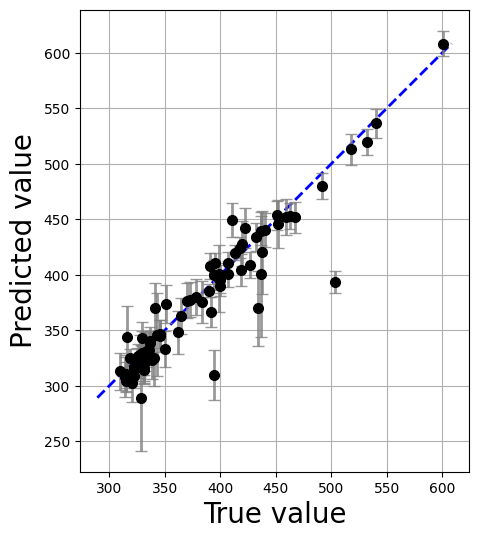

In [22]:
posterior = gp_model.posterior(X_test)
median = posterior.mean.cpu().detach()
std = posterior.variance.cpu().detach()**(1/2)
q1 = median - std
q2 = median + std
cv_plot(median, q1, q2, y_test)

In [23]:
print(r2_score(median.squeeze(1), y_test.cpu().detach().squeeze(1)))
print(mean_absolute_error(median.squeeze(1), y_test.cpu().detach().squeeze(1)))

0.8807364374893456
12.612753


### Testing BoTorch compatibility

In [24]:
from botorch.acquisition import qExpectedImprovement
from botorch.sampling import SobolQMCNormalSampler

In [26]:
qmc_sampler = SobolQMCNormalSampler(sample_shape=32)
qEI = qExpectedImprovement(
    model=gp_model, best_f=y_train.max(),
    sampler=qmc_sampler)
print(qEI(X_test.unsqueeze(1)))

tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.5073, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
       device='cuda:0', grad_fn=<MeanBackward1>)
